### GW tutorial 1: Ground-based antenna pattern and redshift horizon

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [7]:
!pip install healpy
!pip install cartopy

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### Network antenna patterns

Interferometric detectors are \textbf{omnidirectional} antennas and have good sensitivity over a large fraction of the sky. The output of the detector will be $h(t)$, which will respond to a passing gravitational wave (GW) as $h_{ij}(t, \mathbf{x})$. The general transfer function for GW detectors is:

\begin{equation}
h(t, \mathbf{x}) = D^{ij} h_{ij}(t, \mathbf{x}),
\end{equation}
where $D^{ij}$ is the detector tensor that depends on its geometry. For a ground-based detector, we can neglect the spatial dependence of the GW signal $h_{ij}(t, \mathbf{x})$, such that:

\begin{equation}
h_{ij}(t) = \sum_{A={+, \times}} e^A_{ij}(\hat{\mathbf{n}}) h_A(t).
\end{equation}

The direction of propagation of the wave is $\hat{\mathbf{k}}$, and $e^A_{ij}$ is the polarization tensor defined as:

\begin{equation}
e^A_{ij}(\hat{\mathbf{k}}) =
\begin{cases}
\hat{\mathbf{u}}_{i} \hat{\mathbf{u}}_{j} - \hat{\mathbf{v}}_{i} \hat{\mathbf{v}}_{j},  & \text{for } A=+ \\
\hat{\mathbf{u}}_{i} \hat{\mathbf{v}}_{j} + \hat{\mathbf{v}}_{i} \hat{\mathbf{u}}_{j},  & \text{for } A=\times
\end{cases}
\end{equation}

where $\hat{\mathbf{u}}$ and $\hat{\mathbf{v}}$ are unit vectors orthogonal to $\hat{\mathbf{k}}$. This would be the case when the polarization angle $\psi$ is negligible, so to add this information we can rewrite the polarization tensor as:

\begin{equation}
e^{\text{rot}, A}_{ij}(\hat{\mathbf{k}}) =
\begin{cases}
\cos(2\psi) e^+_{ij}(\hat{\mathbf{k}}) - \sin(2\psi) e^\times_{ij}(\hat{\mathbf{k}}),  & \text{for } A=+ \\
\sin(2\psi) e^+_{ij}(\hat{\mathbf{k}}) + \cos(2\psi) e^\times_{ij}(\hat{\mathbf{k}}),  & \text{for } A=\times
\end{cases}
\end{equation}


**Exercise 1:** create a function called `polarization_tensors` that returns $e_{ij}^{rot, A}(\hat{\textbf{k}})$  in the celestial frame for both polarizations as a function of the wave propagation $\hat{\textbf{k}}$ and the polarization angle $\psi$. Also, create a function called `direction_propagation` that computes $\hat{\textbf{k}}(\theta, \phi) = [\sin{\theta} \cos{\phi}, \sin{\theta} \sin{\phi}, \cos{\theta}]$

_Hint_: Given a unit sphere the unit vector orthogonal to $\hat{\textbf{k}}$ are $e_{\theta} = [\cos{\theta}\cos{\phi}, \cos{\theta}\sin{\phi}, -\sin{\theta}]$ and $e_{\phi} = [- \sin{\phi}, \cos{\phi}, 0]$

In [13]:
def polarization_tensors(theta, phi, psi):
    """
    Returns the polarization tensors in the celestial frame for both polarizations.
    """
    # Basis vectors orthogonal to k
    e_theta = np.array([np.cos(theta) * np.cos(phi), np.cos(theta) * np.sin(phi), -np.sin(theta)])
    e_phi = np.array([-np.sin(phi),np.cos(phi),0])


        # Plus and cross polarization tensors
    e_plus = np.outer(e_theta, e_theta) - np.outer(e_phi, e_phi)
    e_cross = np.outer(e_theta, e_phi) + np.outer(e_phi, e_theta)

    # Rotated polarization tensors
    e_rot_plus = np.cos(2 * psi) * e_plus - np.sin(2 * psi) * e_cross
    e_rot_cross = np.sin(2 * psi) * e_plus + np.cos(2 * psi) * e_cross

    return {"plus": e_rot_plus, "cross": e_rot_cross}


def direction_propagation(theta, phi):
    """
    Computes the wave propagation unit vector
    """

    k = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi),np.cos(theta) ])
    return k

def example_run_1():
    # Example Usage
    theta = np.pi / 4  # 45 degrees
    phi = np.pi / 6    # 30 degrees
    psi = np.pi / 3    # 60 degrees

    k_vec = direction_propagation(theta, phi)
    polarization = polarization_tensors(theta, phi, psi)

    print("Propagation Vector (k):\n", k_vec)
    print("Rotated Plus Polarization Tensor (e_rot_plus):\n", polarization["plus"])
    print("Rotated Cross Polarization Tensor (e_rot_cross):\n", polarization["cross"])


#run if want to see example values outputted
example_run_1()

Propagation Vector (k):
 [0.61237244 0.35355339 0.70710678]
Rotated Plus Polarization Tensor (e_rot_plus):
 [[ 0.46783009 -0.63094574 -0.08967987]
 [-0.63094574 -0.21783009  0.65533009]
 [-0.08967987  0.65533009 -0.25      ]]
Rotated Cross Polarization Tensor (e_rot_cross):
 [[ 0.41443939  0.3857233  -0.5517767 ]
 [ 0.3857233  -0.8474521   0.08967987]
 [-0.5517767   0.08967987  0.4330127 ]]


Now, we have the polarization tensors taking into account the polarization angle $\psi$. However, this is in celestial coordinates and we need to rotate our vectors according to the local detector frame.

**Exercise 2:** Assuming that a given detector is located at $(\theta_{0}, \phi_{0})$ write a function called rotation matrix.

_Hint_: we need to rotate the z-axis to account for $\theta_0$ and to rotate the x-axis for $\phi_{0}$, so that $R = R_{x}(\pi/2 - \phi_{0}) \cdot R_{z}(\pi /2 +\theta_{0})$

In [9]:
def rotation_matrix(theta0, phi0):
    """
    Computes the rotation matrix R
    used the standard 3D z-axis rotation matrix as a basis
    """
    # Rotation around z-axis by (pi/2 + theta0)
    Rz = np.array([[np.cos(np.pi/2 + theta0), -np.sin(np.pi/2 + theta0), 0],
                   [np.sin(np.pi/2 + theta0), np.cos(np.pi/2 + theta0), 0],
                   [0, 0, 1]
    ])

    # Rotation around x-axis by (pi/2 - phi0)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(np.pi/2 - phi0), -np.sin(np.pi/2 - phi0)],
        [0, np.sin(np.pi/2 - phi0), np.cos(np.pi/2 - phi0)]
    ])

    return Rx @ Rz  # Matrix multiplication to get the final rotation matrix


def example_run_2():
    # Example Usage
    theta = np.pi / 4  # 45 degrees
    phi = np.pi / 6    # 30 degrees
    psi = np.pi / 3    # 60 degrees

    k_vec = direction_propagation(theta, phi)
    polarization = polarization_tensors(theta, phi, psi)
    rotation_mat = rotation_matrix(theta, phi)

    print("Propagation Vector (k):\n", k_vec)
    print("Rotated Plus Polarization Tensor (e_rot_plus):\n", polarization["plus"])
    print("Rotated Cross Polarization Tensor (e_rot_cross):\n", polarization["cross"])
    print("Rotation Matrix (R):\n", rotation_mat)


example_run_2()

Propagation Vector (k):
 [0.61237244 0.35355339 0.70710678]
Rotated Plus Polarization Tensor (e_rot_plus):
 [[ 0.46783009 -0.63094574 -0.08967987]
 [-0.63094574 -0.21783009  0.65533009]
 [-0.08967987  0.65533009 -0.25      ]]
Rotated Cross Polarization Tensor (e_rot_cross):
 [[ 0.41443939  0.3857233  -0.5517767 ]
 [ 0.3857233  -0.8474521   0.08967987]
 [-0.5517767   0.08967987  0.4330127 ]]
Rotation Matrix (R):
 [[-0.70710678 -0.70710678  0.        ]
 [ 0.35355339 -0.35355339 -0.8660254 ]
 [ 0.61237244 -0.61237244  0.5       ]]


So far we have computed the `R = rotation_matrix(theta_0, phi_0)`, the direction of propagation `k = direction_propagation(theta, phi)` and the polarization tensors $e_+$ and $e_{\times}$ with the `polarization_tensors` function. Now, we have all the ingredients to calculate the antenna pattern.


For an L shape detector such as current Advanced LIGO and Advanced Virgo the output of the detector the antenna pattern defined as $F = F_{+}^2 + F_{\times}^{2}$ where

$F_{+}(\theta, \phi, \psi) = \frac{1}{2}[(d_{x}^{T} e_{+}^{local} d_{x})- (d_{y}^{T} e_{+}^{local} d_{y})],$

$F_{\times}(\theta, \phi, \psi) = \frac{1}{2}[(d_{x}^{T} e_{\times}^{local} d_{x})- (d_{y}^{T} e_{\times}^{local} d_{y})].$

Here, $d_{x}$ and $d_{y}$ are the directions of the detector arms in the local frame are defined as:
$
\mathbf{d}_x =
\begin{bmatrix}
\cos\alpha \\
\sin\alpha \\
0
\end{bmatrix},
\quad
\mathbf{d}_y =
\begin{bmatrix}
-\sin\alpha \\
\cos\alpha \\
0
\end{bmatrix}.
$

**Excercise 3:** Create a function called `antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha)`.


_Hint:_ The wave propagation vector $\mathbf{k}$ and polarization tensors $e_+$ and $e_\times$ are transformed to the detector's local frame as follows:

$
\mathbf{k}_\text{local} = R \cdot \mathbf{k}(\theta, \phi),
$

$
e_+^\text{local} = R \cdot e_+ \cdot R^\mathsf{T},
$

$
e_\times^\text{local} = R \cdot e_\times \cdot R^\mathsf{T},
$

where $R^{T}$ denotes the transpose of the rotation matrix \(R\).



In [10]:
def antenna_pattern(theta, phi, psi, theta0, phi0, alpha):
    """
    Computes the antenna pattern for a detector at (theta0, phi0) with arm orientation alpha.
    """
    # Compute the rotation matrix
    R = rotation_matrix(theta0, phi0)

    # Compute the wave propagation vector in the local frame
    k_local = R @ direction_propagation(theta, phi)

    # Compute the polarization tensors in the local frame
    pol_tensors = polarization_tensors(theta, phi, psi)
    e_plus_local = R @ pol_tensors["plus"] @ R.T
    e_cross_local = R @ pol_tensors["cross"] @ R.T

    # Detector arm directions in the local frame
    d_x = np.array([np.cos(alpha), np.sin(alpha), 0])
    d_y = np.array([-np.sin(alpha), np.cos(alpha), 0])

    # Compute the antenna response functions
    F_plus = 0.5 * (d_x.T @ e_plus_local @ d_x - d_y.T @ e_plus_local @ d_y)
    F_cross = 0.5 * (d_x.T @ e_cross_local @ d_x - d_y.T @ e_cross_local @ d_y)

    # Compute the antenna pattern
    F = np.sqrt(F_plus**2 + F_cross**2)

    return {"F_plus": F_plus, "F_cross": F_cross, "F": F}


def example_run_3():
    theta = np.pi / 4  # 45 degrees
    phi = np.pi / 6    # 30 degrees
    psi = np.pi / 3    # 60 degrees
    theta0 = np.pi / 4  # Detector latitude
    phi0 = np.pi / 6    # Detector longitude
    alpha = np.pi / 4   # Detector arm orientation

    antenna_response = antenna_pattern(theta, phi, psi, theta0, phi0, alpha)

    print("Antenna Response (F_plus):", antenna_response["F_plus"])
    print("Antenna Response (F_cross):", antenna_response["F_cross"])
    print("Antenna Pattern (F):", antenna_response["F"])


example_run_3()

Antenna Response (F_plus): 0.17497355940866105
Antenna Response (F_cross): -0.5984482324649862
Antenna Pattern (F): 0.6235030340203667


Alright, now let's see what this antenna pattern looks like. Below I coded a function to plot it (you are welcome). If everything looks fine it should look like the plot on the slides.

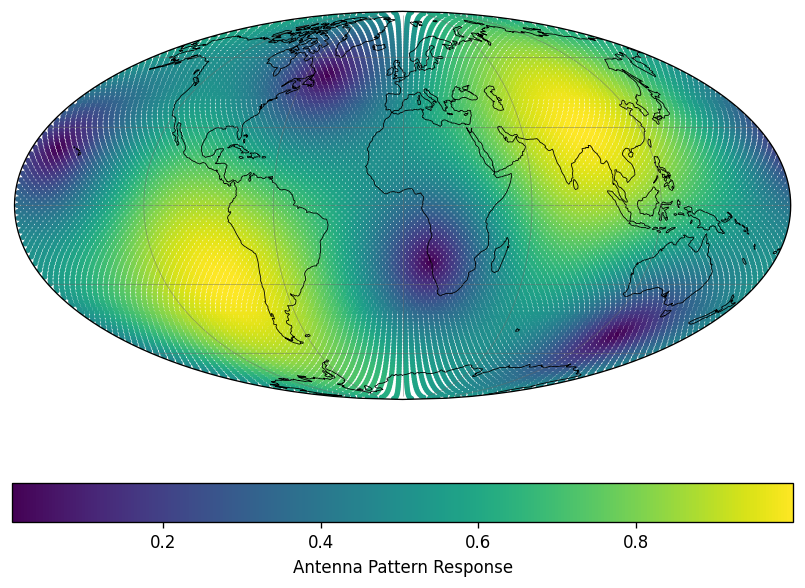

In [11]:
def plot_antenna_pattern(theta_0, phi_0, alpha, psi, nside=32):
    """
    Plot the antenna pattern using Cartopy
    theta_0, phi_0: Detector location (longitude and latitude in radians)
    alpha: Detector orientation (angle of x-arm relative to North in radians)
    psi: Polarization angle
    nside: Resolution parameter for Healpix map
    """
    npix = hp.nside2npix(nside)
    antenna_map = np.zeros(npix)

    # Compute the antenna pattern
    for pix in range(npix):
        theta, phi = hp.pix2ang(nside, pix)
        antenna_map[pix] = antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha)["F"]
        #antenna_map[pix] = antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha)

    # Healpy's pixel centers for plotting (convert to degrees)
    lon, lat = hp.pix2ang(nside, np.arange(npix), lonlat=True)  # Lon/lat in degrees
    lat = np.radians(lat)  # Convert latitude to radians for Cartopy
    lon = np.radians(lon)  # Convert longitude to radians for Cartopy

    # Create a Mollweide plot using Cartopy
    fig = plt.figure(figsize=(12, 6), dpi=120)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

    # Plot the antenna pattern on Cartopy map
    pc = ax.scatter(lon * 180 / np.pi, lat * 180 / np.pi, c=antenna_map, cmap="viridis", s=5, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines(color='black', linewidth=0.5)
    ax.set_global()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='dimgrey', alpha=0.5)

    # Add colorbar
    cbar = fig.colorbar(pc, orientation="horizontal", shrink=0.7)
    cbar.set_label("Antenna Pattern Response")
    plt.show()


# Detector location: LIGO Livingston
lat = 30  # Latitude in degrees
lon = -90  # Longitude in degrees
yangle = 160.0  # Y-arm orientation in degrees (clockwise from North)

# Convert to radians for computation
theta_0 = np.radians(lon)
phi_0 = np.radians(lat)
alpha = np.radians(yangle - 90)  # Convert Y-arm to x-arm orientation
psi = 0  # Polarization angle

plot_antenna_pattern(theta_0, phi_0, alpha, psi)


Good job! You are almost at the end of the first part. Now, what can you tell me about the "blind" spots of the detector? Where are they located? Where is the best place to see a gravitational wave?


MY RESPONSE:

The blind spots of the detectors are the areas colored purple (bottom of Africa, east coast of Canada, and near Hawaii). The best spots are those colored yellow and green (west coast of South America and the area around China).




**Excersice 4:** What about other detectors? Can you remake this plot? See details below:

- _LIGO Hanford:_ lat = 46.45, lon = -119.41, yangle = 171.8

- _Virgo:_ lat = 43.63, lon = 10.5, yangle = 250.0a

Plotting antenna pattern for LIGO Hanford...


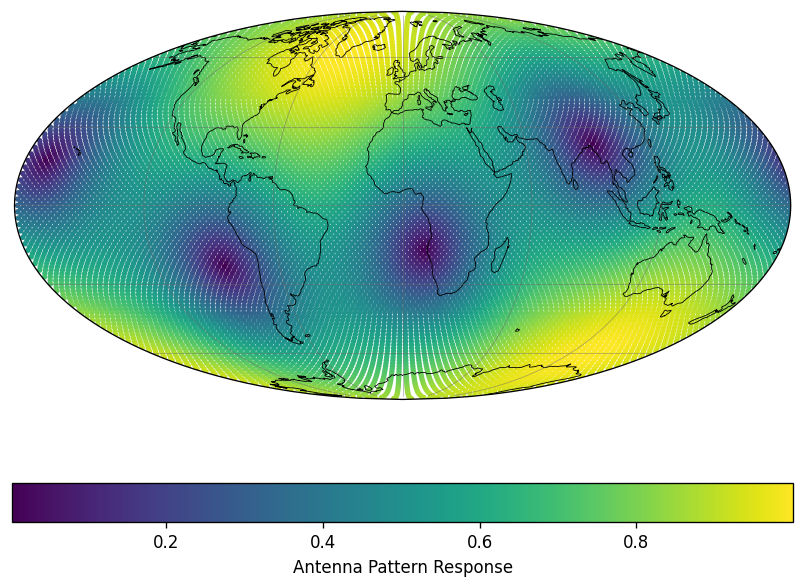

Plotting antenna pattern for Virgo...


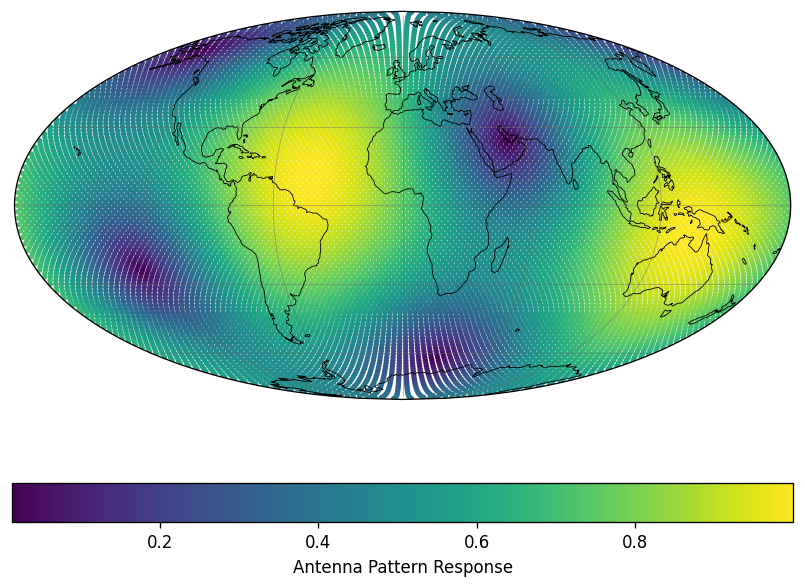

In [15]:

# Detector Locations for Exercise 4
detectors = {
    "LIGO Hanford": {"lat": 46.45, "lon": -119.41, "yangle": 171.8},
    "Virgo": {"lat": 43.63, "lon": 10.5, "yangle": 250.0}
}

# Iterate over detectors and plot their antenna patterns
for name, params in detectors.items():
    theta_0 = np.radians(params["lat"])
    phi_0 = np.radians(params["lon"])
    alpha = np.radians(params["yangle"] - 90)  # Convert Y-arm to x-arm orientation
    psi = 0  # Polarization angle

    print(f"Plotting antenna pattern for {name}...")
    plot_antenna_pattern(theta_0, phi_0, alpha, psi)

Do you want a curiosity about the detection of the first binary neutron star? [Here](https://dcc.ligo.org/public/0146/G1701985/001/bayestar_no_virgo.png) is the sky map. Where is it located? What can Virgo see? Is it a good thing or a bad thing?